<a href="https://colab.research.google.com/github/danielalcalde/MCMC_CRBM/blob/master/Ising_CRBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating the Ising model using a CRBM




## Abstract:
Machine learning is becoming widely used in analyzing the thermodynamics of many-body condensed matter systems. Restricted Boltzmann Machine (RBM) aided Monte Carlo simulations have sparked interest recently, as they manage to speed up classical Monte Carlo simulations. Here we employ the Convolutional Restricted Boltzmann Machine (CRBM) method and show that its use helps to reduce the number of parameters to be learned drastically by taking advantage of translation invariance. Furthermore, we show that it is possible to train the CRBM at smaller lattice sizes, and apply it to larger lattice sizes. To demonstrate the efficiency of CRBM we apply it to the paradigmatic Ising and Kitaev models in two-dimensions.

## Paper:
https://arxiv.org/abs/2008.05401

## Introduction
This Notebook is intended as an educational tool for the use of Convolutional Restricted Boltzmann Machines in classical Montecarlo simulations. The code for the paper was written with the library Theano, which will no longer be updated, that is why we have chosen to present the main concept in TensorFlow. Specifically, this notebook only tackles the Ising model. As there is only the nearest neighbor interaction, we can teach the CRBM using $3\times3$ states, this has as a consequence that we can generate all possible states $2^{3\times3}= 512$ and learn the energy function from them. So no Metropolis is necessary, and no sampling of the CRBM while training is necessary. Also contrary to the main work, for simplicity, no correction step or parallel tempering is introduced. Note that for the Ising model there exist cluster algorithms that would outperform the CRBM.


# Installing tensorflow

In [4]:
"""
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tensorflow-gpu==2.1.0"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)
""";

# Importing necessary libraries

In [5]:
import numpy as np
import tensorflow as tf
from IPython import display
import pandas as pd
import time
import matplotlib.pyplot as plt

In [6]:
import sys
sys.path.append('../')
import ising_analysis
import importlib
importlib.reload(ising_analysis)

<module 'ising_analysis' from '/Users/ecasiano/Desktop/IsingConvolutionalRBM/ising_analysis.py'>

Set seed for reproducibility.

In [7]:
np.random.seed(0)
tf.random.set_seed(0)

Accuracy used for training and numerics.

In [8]:
floatX = np.float32

In [9]:
t0 = time.time()

# Helping functions

Tensorflow has no implementation of the binomial function. With help of random.uniform the beahviour can be replicated.

In [10]:
def binomial(means):
    return (tf.sign(means - tf.random.uniform(tf.shape(means))) + 1 ) / 2

In [11]:
binomial(np.array([0.5, 0.5, 0.1, 0.9]))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 0., 1.], dtype=float32)>

This functions creates periodic padding so that the convolution has periodic boundary conditions. When performing the transposed convolution step the padding is placed at the oposite side.

In [12]:
def periodic_padding(x, kernel_size=2, deconv=False):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    pad_r = kernel_size // 2
    pad_l = kernel_size - pad_r - 1
    
    d1, d2 = x.shape[1: 3]
    
    # When deconvolving the pading should reverses
    if deconv:
        p = pad_r
        pad_r = pad_l
        pad_l = p   

    top_left = x[:, d1 - pad_l:, d2 - pad_l:]
    top_center = x[:, d1 - pad_l:, :]
    top_right = x[:, d1 - pad_l:, :pad_r]

    middle_left = x[:, :, d2 - pad_l:]
    middle_center = x
    middle_right = x[:, :, :pad_r]

    bottom_left = x[:, :pad_r, d2 - pad_l:]
    bottom_center = x[:, :pad_r, :]
    bottom_right = x[:, :pad_r, :pad_r]
    
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x

a = tf.Variable(np.arange(4 * 4).reshape(1, 4, 4))
print(a[0].numpy())
print()
print(periodic_padding(a,2)[0].numpy())

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

[[ 0  1  2  3  0]
 [ 4  5  6  7  4]
 [ 8  9 10 11  8]
 [12 13 14 15 12]
 [ 0  1  2  3  0]]


# Dataset Generation

In [13]:
def to_int(x):
    if x == '0' or x == '1': return int(x)
    else: return 0

#This will generate all posible LxL matrices with {0,1}^(LxL) don't use with more then L=4
def bit_string(L):
    maxim = 2 ** (L ** 2)
    a = np.asarray([[to_int(x) for x in list(('{0:' + str(L ** 2) + 'b}').format(i))] for i in range(maxim)], dtype=floatX)
    return a.reshape(2 ** (L ** 2), L, L)

Generate all posible $3\times3$ states

In [14]:
states_train = bit_string(3)[:, :, :, None]
states_train.shape

(512, 3, 3, 1)

Generate a random test set of lattice size $L=50$ to evaluate if the CRBM matches the Ising model at large lattice sizes.

In [15]:
L = 40
states_test = np.asarray(np.random.binomial(size=(4 * 10 ** 3, L, L, 1), p=0.5, n=1), dtype=floatX)
states_test.shape

(4000, 40, 40, 1)

Define the energy of given state for the Ising model: $E(s)=-\sum_{<ij>}s_is_j$

In [16]:
def ising_energy(states):
    states = 2 * states - 1

    nb = np.roll(states, shift=-1, axis=1) + np.roll(states, shift=-1, axis=2)

    return -np.sum(states * nb, axis=(1, 2, 3))

For now we will only consider the case $T=1$


In [17]:
temp = 2.25

The physical energy is computed for train and test set.

In [18]:
E_phys_train = ising_energy(states_train)
E_phys_test = ising_energy(states_test)
E_phys_train.shape

(512,)

The CRBM will be trained by batches of 64 states.

In [19]:
TRAIN_BUF = E_phys_train.shape[0]
BATCH_SIZE = 2 ** 6
N_TRAIN_BATCHES = TRAIN_BUF// BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((states_train, E_phys_train)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
BATCH_SIZE

64

In [20]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 3, 3, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# The Model

Random Initializion: the kernel W with kernel_dims=(kernel_number, kernel_size) and both biases.

In [21]:
kernel_dims = (1,3)
kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0])

multi = np.prod(kernel_shape)
W_np = np.asarray(np.random.randn(*kernel_shape) * np.sqrt(2 / multi), dtype=floatX)

W = tf.Variable(W_np * 2)

vbias = tf.Variable(np.zeros(1, dtype=floatX))
hbias = tf.Variable(np.zeros(kernel_dims[0], dtype=floatX))

print("vbias.shape:", vbias.shape)
print("hbias.shape:", hbias.shape)
print("W.shape:", W.shape)

vbias.shape: (1,)
hbias.shape: (1,)
W.shape: (3, 3, 1, 1)


Analytical mapping from the Ising model to the CRBM (see App. C in paper):

In [22]:
def get_param(beta):
    e4b = np.exp(4 * beta)
    e2b = np.exp(2 * beta)

    W = np.log(-1 + 2 * e4b + 2 * e2b * np.sqrt(e4b - 1))

    Wk = np.zeros((2, 2, 1, 2), dtype=floatX)
    Wk[0, :, 0, 0] = W
    Wk[:, 0, 0, 1] = W

    vbias = np.asarray([-2 * W], dtype=floatX)
    hbias = np.array([-W, -W], dtype=floatX)

    return Wk, vbias, hbias

W, vbias, hbias = [tf.Variable(param) for param in get_param(1 / temp)]

The negative log likelihood also called free energy: \\
$F(v) = -v_\text{bias} \sum_{i,j} v_{ij} -\sum_{i,j,k} \log(1+e^{(v*W^k)_{ij} +h^k_\text{bias}})$

In [23]:
def n_log_like(v):
    input4D = periodic_padding(v, kernel_dims[1])
    kernels4D = W

    # Convolution
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
    out += hbias[None, None, None, :]

    # Same as softplus(x)=log(1 + exp(x))
    hidden_term_not = tf.math.softplus(out)
    hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

    visible_term = tf.reduce_sum(v, axis=(1, 2)) * vbias[None, :]
    visible_term = tf.reduce_sum(visible_term, axis=1)

    return -hidden_term - visible_term

$P(h|x): x \rightarrow h$  
$P(h^k_{ij}=1|v)=\sigma((W^k * v)_{ij} + h_\text{bias}^k) ) $

In [24]:
def prop_vis_to_hid(v):
    input4D = periodic_padding(v, kernel_dims[1])
    kernels4D = W

    # Convolution
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")

    out += hbias[None, None, None, :]

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation), mean_activation

h, act = prop_vis_to_hid(states_train[100][None])
print("visible_shape:", states_train[100][None].shape)
print("hidden_shape:", h.shape)

visible_shape: (1, 3, 3, 1)
hidden_shape: (1, 4, 4, 2)


$P(x|h): h \rightarrow x$  
$P(v_{ij}=1|h)=\sigma((\sum_k \bar{W}^k * h^k)_{ij} +v_\text{bias}))$


In [25]:
def prop_hid_to_vis(h):
    input4D = periodic_padding(h, kernel_dims[1], deconv=True)
    kernels4D = tf.transpose(W[::-1, ::-1], [0, 1, 3, 2])

    # Convolution
    out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")

    out += vbias[None, None, None, :]

    mean_activation = tf.math.sigmoid(out)
    return binomial(mean_activation), mean_activation

$P(x'|x): x \rightarrow h\rightarrow x'$

In [26]:
def gibbs(state):
    h, h_act = prop_vis_to_hid(state)
    new_state, x_act = prop_hid_to_vis(h)
    return new_state, x_act, h, h_act

Plot the intermidiary states

In [27]:
def arrow(ax):
    ax.arrow(0., 0.5, 0.5, 0, head_width = 0.2, width = 0.05)
    ax.axis('off')

In [28]:
def plot_sampling(x, x_act, h, h_act):
    fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(9 * 2, 3 * 2))
    axes[1, 0].imshow(x_old[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 0].set_xlabel("x", fontsize=20)
    arrow(axes[1, 1])

    # Remove unwanted plots
    for ij in [(0,0), (2,0), (0,1), (2,1), (1,2), (1,3), (1, 4), (0,5), (2, 5), (0,6), (2, 6), (0, 7), (2, 7), (0, 8), (2, 8)]:
        axes[ij[0], ij[1]].set_visible(False)

    for i in range(2):
        axes[2*i, 2].imshow(h_act[0, :, :, i], vmin=0, vmax=1, cmap="gray")
        axes[2*i, 2].set_xlabel(f'$P(h^{i}|x)$', fontsize=20)
        
        arrow(axes[2*i, 3])

        axes[2*i, 4].imshow(h[0, :, :, i], vmin=0, vmax=1, cmap="gray")
        axes[2*i, 4].set_xlabel(f'$h^{i}$', fontsize=20)
        
        

    arrow(axes[1, 5])
    axes[1, 6].imshow(x_act[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 6].set_xlabel("P(x'|h)", fontsize=20)

    arrow(axes[1, 7])

    axes[1, 8].imshow(x[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    axes[1, 8].set_xlabel("x'", fontsize=20)
    # Deactivate axes
    for j in range(9):
        for i in range(3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

    plt.show()

In [29]:
x_old = np.asarray(np.random.binomial(n=1, p=0.1, size=(1, 5, 5, 1)), dtype=floatX) * 0
x_old[0, 2, 1, 0] = 1
x_old[0, 2, 2, 0] = 1
x_old[0, 2, 3, 0] = 1

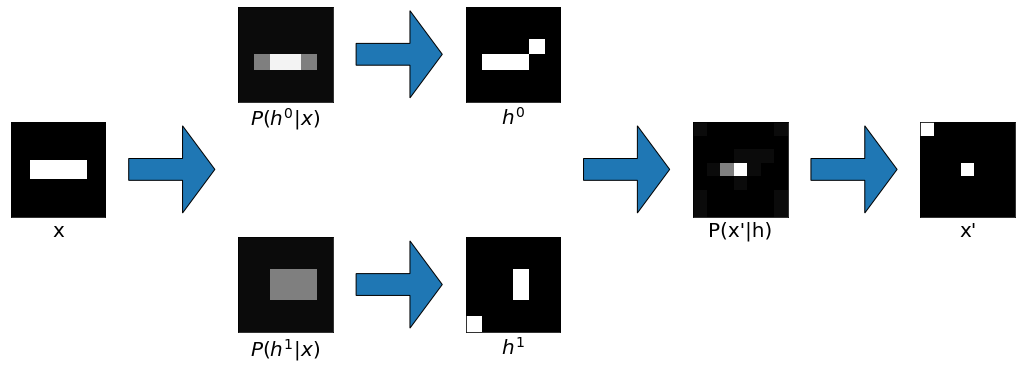

In [30]:
#W, vbias, hbias = [tf.Variable(param) for param in get_param(1 / 100)]
plot_sampling(*gibbs(x_old))

Computing the loss function:  
$\text{diff}(x) = E(x) - F(x)$  
$C = \frac{1}{M} \sum_x \text{diff}(x)$  
$\text{loss} = \sum_x (\text{diff}(x) - C)^2$  
If the parameters where initialized with the analytical solution the loss will only differ slightly from zero because of numerical errors

In [31]:
@tf.function
def compute_loss(x, nll_phys):
    nll_crbm = n_log_like(x)

    diff = nll_phys - nll_crbm # E_phys(x) - F_RBM(x)
    C = tf.reduce_mean(diff)

    loss = tf.reduce_mean((diff - C) ** 2)
    return loss

print("Train_loss:", compute_loss(states_train, E_phys_train / temp).numpy())
print("Test_loss:", compute_loss(states_test, E_phys_test / temp).numpy())

Train_loss: 86.6186
Test_loss: 568.33685


Initialize the adam optimizer, compute the gradients and apply them.

In [32]:
opt = tf.keras.optimizers.Adam()
params = [W, hbias, vbias]
def compute_grad(x, nll_phys):
    ### pass through network
    with tf.GradientTape() as tape:
        loss = compute_loss(x, nll_phys)

    # compute the grad
    grad = tape.gradient(loss, params)
    return grad, loss

@tf.function
def train(x, nll_phys):
    grad, loss = compute_grad(x, nll_phys)

    opt.apply_gradients(zip(grad, params))
    return loss

train(states_train, E_phys_train / temp)

<tf.Tensor: shape=(), dtype=float32, numpy=86.6186>

Everything combined in one class.

In [33]:
class CRBM:
    def __init__(self, kernel_dims, opt=None):
        
        assert len(kernel_dims) == 2
        if opt is None:
            opt = tf.keras.optimizers.Adam()
            
        self.opt = opt
        
        self.kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0])
        self.kernel_dims = kernel_dims


        multi = np.prod(self.kernel_shape)
        W_np = np.asarray(np.random.randn(*self.kernel_shape) * np.sqrt(2 / multi), dtype=floatX)

        W = tf.Variable(W_np)

        vbias = tf.Variable(np.zeros(1, dtype=floatX))
        hbias = tf.Variable(np.zeros(kernel_dims[0], dtype=floatX))

        self.W = W
        self.hbias = hbias
        self.vbias = vbias


        # Learning parameters
        self.params = [self.W, self.vbias, self.hbias]


    def n_log_like(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        out += self.hbias[None, None, None, :]

        # Same as softplus(x)=log(1 + exp(x))
        hidden_term_not = tf.math.softplus(out)
        hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

        visible_term = tf.reduce_sum(v, axis=(1, 2)) * self.vbias[None, :]
        visible_term = tf.reduce_sum(visible_term, axis=1)

        return -hidden_term - visible_term

    def set_analytical_param(self, beta):
        W, vbias, hbias = get_param(beta)
        self.W.assign(W)
        self.hbias.assign(hbias)
        self.vbias.assign(vbias)

    def prop_vis_to_hid(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W
        
        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.hbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        return binomial(mean_activation)
        
    
    def prop_hid_to_vis(self, h):
        input4D = periodic_padding(h, self.kernel_dims[1], deconv=True)
        kernels4D = tf.transpose(self.W[::-1, ::-1], [0, 1, 3, 2])

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.vbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        return binomial(mean_activation)
    
    @tf.function
    def gibbs(self, state):
        return self.prop_hid_to_vis(self.prop_vis_to_hid(state))
    
    
    @tf.function
    def gibbs_k(self, state, k=1):
        
        i = tf.constant(0)
        cond = lambda i, state: tf.less(i, k)

        def operation(i, state):
            i += 1
            state = self.gibbs(state)
            return i, state

        _, state = tf.while_loop(cond, operation, [i, state])
        
        return state
    
    @tf.function
    def compute_loss(self, x, nll_phys):
        nll_crbm = self.n_log_like(x)

        diff = nll_phys - nll_crbm
        C = tf.reduce_mean(diff)
        
        loss = tf.reduce_mean((diff - C) ** 2)
        return loss
    
    def compute_grad(self, x, nll_phys):
        # compute the grad

        ### pass through network
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x, nll_phys)

        grad = tape.gradient(loss, self.params)
        return grad, loss


    @tf.function
    def train(self, x, nll_phys):
        grad, loss = self.compute_grad(x, nll_phys)

        self.opt.apply_gradients(zip(grad, self.params))
        return loss
    
    # Symmetrization functions
    def generate_R90_groups(self):
        
        # Should generalize to even linear size kernels

        L = self.kernel_dims[1]
        
        unique_vectors = []
        length = L-1
        for i in range(L//2):
            for j in range(i,i+length):

                unique_vectors.append([i,j])

            length -= 2
        unique_vectors = np.array(unique_vectors,dtype=np.float32)
        
        # Shift vectors to place origin at center site (for odd) or center (for even) 
        if L%2!=0:
            shift = L//2
        else:
            shift = (L//2-0.5)
        unique_vectors -= shift
            
        # Apply rotation matrix to get the 4 rotations
        R = np.array([[0,1],[-1,0]])
        rotations = np.zeros((unique_vectors.shape[0],4,2),dtype=np.float32)
        for i,vec in enumerate(unique_vectors):
            for rot in range(4):
                rotations[i][rot] = vec
                vec = R@vec

        # Shift rotationally equivalent vectors back to have center at top left corner
        rotations += shift
        rotations = rotations.astype(np.int32)
        return rotations

    # @tf.function
    def symmetrize_rotations(self,R90_groups):
        for group in R90_groups:
            W_mean = tf.zeros(kernel_dims[0])
            for angle in range(4):
                row,col = group[angle]
                W_mean += self.W[row,col] 
            W_mean /= 4.0

            for angle in range(4):
                row,col = group[angle]
                self.W[row,col].assign(W_mean)

    # Symmetrization functions
    @tf.function
    def symmetrize_reflections(self):
        
        kernel_size = self.kernel_dims[1]
        
        if kernel_size%2 !=0: 
            start_right = kernel_size//2+1
        else:
            start_right = kernel_size//2
        start_bottom = start_right
        
        # Get left-half of Ising lattice
        # print("kernel_size: ",kernel_size)
        # print("kernel_size//2: ",kernel_size//2)
        left_half = self.W[:,0:kernel_size//2,:,:]
        right_half = self.W[:,start_right:,:,:]
        right_half = right_half[:,::-1,:,:] # Reflection of right-half

        # Take average of sites symmetrical about vertical axis
        left_right_mean = (left_half+right_half)/2.0
        
        self.W[:,0:kernel_size//2,:,:].assign(left_right_mean)
        self.W[:,start_right:,:,:].assign(left_right_mean[:,::-1,:,:])
        
        # Get top-half of Ising lattice
        # print("kernel_size: ",kernel_size)
        # print("kernel_size//2: ",kernel_size//2)
        top_half = self.W[0:kernel_size//2,:,:,:]
        bottom_half = self.W[start_bottom:,:,:,:]
        bottom_half = bottom_half[::-1,:,:,:] # Reflection of bottom-half

        # Take average of sites symmetrical about horizontal axis
        top_bottom_mean = (top_half+bottom_half)/2.0
        
        self.W[0:kernel_size//2,:,:,:].assign(top_bottom_mean)
        self.W[start_bottom:,:,:,:].assign(top_bottom_mean[::-1,:,:,:])

# Training

We create an CRBM object and train it. One can see that both the train_loss and the test_loss decrease simulaniously. The expected difference between the two losses should be around $\frac{t_{test}}{t_{train}}=\frac{N_{test}^2}{N^2_{train}}=\frac{50^2}{3^2}=277.77$. Note that our objective is that $F_{RBM}(x)=\beta E(x)+C$.

In [34]:
crbm = CRBM(kernel_dims=kernel_dims)

In [35]:
R90_groups = crbm.generate_R90_groups()
R90_groups

array([[[0, 0],
        [0, 2],
        [2, 2],
        [2, 0]],

       [[0, 1],
        [1, 2],
        [2, 1],
        [1, 0]]], dtype=int32)

In [36]:
loss_train = []
loss_test = []
epoch = 0

In [37]:
%%time
l_train = 10 ** 9
l_test = 10 ** 9

while l_train > 10 ** -6:
    # train
    l_train = 0
        
    for train_s, train_E in train_dataset:
        l_train += crbm.train(train_s, train_E / temp)
        
#         # Symmetrize 90 degree rotations
#         crbm.symmetrize_rotations(R90_groups)
        
#         # Symmetrize horizontal,vertical axis reflections
#         crbm.symmetrize_reflections()
    
    l_train = l_train / N_TRAIN_BATCHES
        
    # plot results    
    if epoch % 1000 == 0:
        l_test = crbm.compute_loss(states_test, E_phys_test / temp)
        
        loss_train.append(l_train) 
        loss_test.append(l_test)
        
        display.clear_output(wait=True)

        print(
            f"Epoch: {epoch} | loss test: {loss_test[-1]}| loss train: {loss_train[-1]}| ltest/ltrain: {loss_test[-1]/loss_train[-1]}"
        )
        # plt.plot(loss_train)
        # plt.plot(loss_test)
        # plt.yscale("log")
        # plt.show()
    epoch += 1
# plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'_training.dat')
# plt.show()

Epoch: 16000 | loss test: 0.006576021201908588| loss train: 8.51648746902356e-06| ltest/ltrain: 772.1517944335938
CPU times: user 4min 39s, sys: 3min 51s, total: 8min 31s
Wall time: 7min 28s


In [38]:
modelType='no_symmetries'

In [43]:
loss_test[-1]/loss_train[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=772.1518>

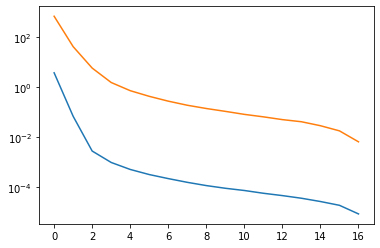

In [57]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.yscale("log")
plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'_training.pdf')
plt.show()

In [58]:
l_train

<tf.Tensor: shape=(), dtype=float32, numpy=9.742473e-07>

## The learned convolutional kernels show the effective interaction between nearest neighbours.

IndexError: index 1 is out of bounds for axis 3 with size 1

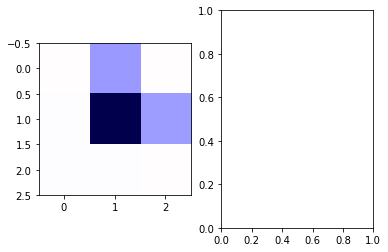

In [59]:
W = crbm.W.numpy()
vmax = np.max(abs(W))

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(W[:, :, 0, 0], vmin =-vmax, vmax=vmax, cmap="seismic")
axes[1].imshow(W[:, :, 0, 1], vmin =-vmax, vmax=vmax, cmap="seismic")
# axes[2].imshow(W[:, :, 0, 2], vmin =-vmax, vmax=vmax, cmap="seismic")
# axes[3].imshow(W[:, :, 0, 3], vmin =-vmax, vmax=vmax, cmap="seismic")

# Deactivate axes
for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_yticks([])
    axes[j].set_xlabel(f'$W^{j}$', fontsize=20)

plt.show()

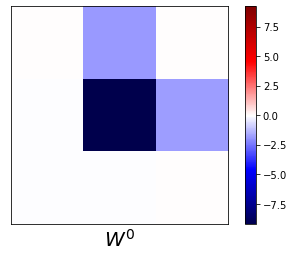

In [60]:
W = crbm.W.numpy()
vmax = np.max(abs(W))

plt.imshow(W[:, :, 0, 0], vmin =-vmax, vmax=vmax, cmap="seismic")
plt.xticks([])
plt.yticks([])
plt.xlabel(f'$W^{0}$', fontsize=20)
plt.colorbar()
# plt.savefig('T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.pdf',dpi=300)

In [61]:
for i in range(kernel_dims[0]):
    print(W[:, :, 0, i],'\n')

[[ 2.2561392e-02 -1.8075216e+00  1.4048695e-03]
 [-4.7327805e-02 -9.1958437e+00 -1.7890625e+00]
 [-3.2068783e-04 -2.9019024e-02  1.9856004e-02]] 



# Sampling

A state with $L=40$ is updated $5\times10 ^4$ times using gibbs sampling.  Because the temperature T=1, is well bellow the critical temperature TC=2.269 it converges to the ground state.

In [101]:
L = 100
states = tf.random.uniform((1, L, L, 1))
# crbm.set_analytical_param(1 / temp)

In [102]:
# Open file for writing
filename = 'L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.dat'
file = open(filename, "w")
header = "#L=%d, T=%.2f \n# E     M \n"
file.write(header)

# Initialize quantities to measure
E = 0.0
M = 12345

bin_size = 1

In [103]:
E

0.0

In [104]:
%%time
epochs = 10 * 10 ** 4
equilibration_steps = 10**6
not_equilibrated = True
Es = []
E_exact = ising_analysis.e_exact_func(temp)*(L**2)
print('Equilibrating...')
i = 0
while i < epochs:
    
    while not_equilibrated:
        states = crbm.gibbs(states)
        i+=1
    
        if i==equilibration_steps:
            print('Equilibrated!')
            print('Sampling and measuring observables...')
            not_equilibrated = False
            i = 0
    
    # After equilibration, measure observables
    states = crbm.gibbs(states)
    E = ising_energy(states)[0]
    Es.append(E)

    file.write('%.2f %.2f \n'%(E/bin_size,M/bin_size))
        
    i += 1
    
print('Done!')

    #     if i % 5000 == 0:
    #         display.clear_output(wait=True)
    #         fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    #         axes[0].imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    #         axes[0].set_xticks([])
    #         axes[0].set_yticks([])
    #         axes[0].set_xlabel('state', fontsize=20)


    #         axes[1].plot(Es)
    #         # axes[1].plot([0, len(Es)], [-2 * L ** 2, -2 * L ** 2])
    #         axes[1].axhline(E_exact)
    #         axes[1].set_xlabel(f'steps', fontsize=20)
    #         axes[1].set_ylabel(f'E', fontsize=20)
    #         display.clear_output(wait=True)
    #         # plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.png',dpi=300)
    #         # plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.pdf',dpi=300)
    #         plt.show()

Equilibrating...
Equilibrated!
Sampling and measuring observables...
Done!
CPU times: user 1h 20min 25s, sys: 4min 47s, total: 1h 25min 12s
Wall time: 1h 19min 35s


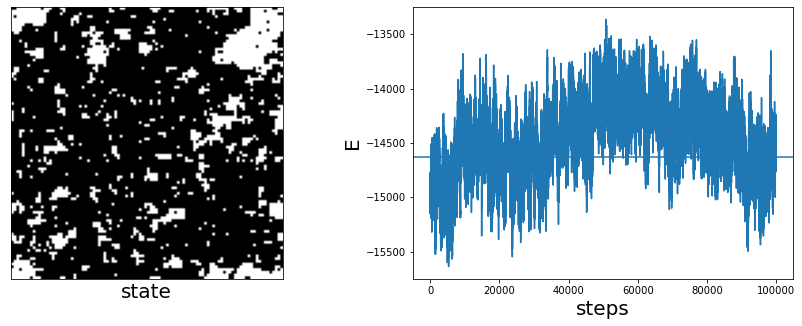

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('state', fontsize=20)


axes[1].plot(Es)
# axes[1].plot([0, len(Es)], [-2 * L ** 2, -2 * L ** 2])
axes[1].axhline(E_exact)
axes[1].set_xlabel(f'steps', fontsize=20)
axes[1].set_ylabel(f'E', fontsize=20)
display.clear_output(wait=True)
# plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.png',dpi=300)
# plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.pdf',dpi=300)
plt.show()

In [111]:
# Close file if finished sampling
file.close()

The minimal energy is $2L^2$

In [112]:
np.mean(Es[:])

-14460.918

In [113]:
E_exact

-14631.027325870677

In [114]:
np.abs(np.mean(Es[:])-E_exact)/np.abs(E_exact)*100

1.1626617415982001

# Thermodynamic constants at different temperatures

Until now we only trained as CRBM at a $T=1$. Train differnt CRBM at different $T$s.




In [ ]:
def train(T, crbm=None):
    if crbm is None:
        crbm = CRBM(kernel_dims=(2, 2))
    
    l_train = 10 ** 9
    l_test = 10 ** 9
    epoch = 0
    while l_train > 10 ** -4:
        # train
        l_train = 0

        for train_s, train_E in train_dataset:
            l_train += crbm.train(train_s, train_E / T)
        
        l_train = l_train / N_TRAIN_BATCHES

        # plot results

        if epoch % 100 == 0:
            l_test = crbm.compute_loss(states_test, E_phys_test / T)

            display.clear_output(wait=True)

            print(
                f"Temp: {T} | Epoch: {epoch} | loss test: {l_test}| loss train: {l_train}"
            )
        epoch += 1
   
    return crbm   

In [37]:
Ts = np.linspace(1.5, 3.5, 25)

Train different CRBM's at different temperatures.

In [38]:
#%%time
#crbms = [train(T) for T in Ts]

Faster. Train a CRBM at a temperature, save it, and then modify it's temperature and retrain it at the new temperature.

In [39]:
"""
%%time
crbm = train(Ts[0])
crbms = [crbm]
T_old = Ts[0]
for T in Ts[1:]:
    crbm_new = CRBM(kernel_dims=(2, 2))
    
    crbm_new.W.assign(crbm.W / T * T_old )
    crbm_new.vbias.assign(crbm.vbias / T * T_old)
    crbm_new.hbias.assign(crbm.hbias / T * T_old)
    
    W_old = crbm_new.W.numpy()
    crbm = train(T, crbm_new)
    W_new = crbm.W.numpy()
    
    crbms.append(crbm)
""";

Alternatively, the CRBM can also be initialized directly with the analytical solution so that no further training is necessary.

In [40]:
crbms = []
for T in Ts:
    crbm = CRBM(kernel_dims=(2, 2))
    crbm.set_analytical_param(1 / T)
    crbms.append(crbm)

# Montecarlo Simulations

The functions performs gibbs steps with a CRBM and saves the energy and magnetization in arrays.

In [41]:
def MC(crbm, states, steps, hidden_steps=10):
    Es = np.empty(steps)
    Ms = np.empty(steps)
    
    for i in range(steps):
        states = crbm.gibbs_k(states, k=hidden_steps)
        
        # Get the state out of the gpu
        state_np = states.numpy()
        Es[i] = ising_energy(state_np)[0]
        Ms[i] = (2 * state_np - 1).sum()
              
    return Es, Ms, states

This function will plot the thermodynamic constants

In [42]:
def plot_thermodynamics(Temp, Es, Cvs, mag, susceptibility):
    # ----------------------------------------------------------------------
    # Plot the Energy, Magnetization, Specific Heat and Susceptibility
    # ----------------------------------------------------------------------

    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    xlabel = "T"
    
    sp = f.add_subplot(2, 2, 1)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Energy ", fontsize=20)
    plt.scatter(Temp, Es)

    sp = f.add_subplot(2, 2, 2)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Magnetization ", fontsize=20)
    plt.scatter(Temp, abs(np.array(mag)))
    plt.axvline(x=2.269)
    
    sp = f.add_subplot(2, 2, 3)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Specific Heat ", fontsize=20)

    plt.scatter(Temp, Cvs)
    plt.axvline(x=2.269)

    sp = f.add_subplot(2, 2, 4);
    plt.xlabel(xlabel, fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    
    plt.scatter(Temp, susceptibility)
    plt.axvline(x=2.269)

    plt.show()

Initialize the step that will be used during the MC. There is an oportunity for parallelization in the Gpu if severall states are updated in the simulation. For simplicity only one states is used.



In [43]:
L = 10
states = tf.random.uniform((1, L, L, 1))

We start with the highest temperature and slowly lower it. First there is a warmup phase and then thermodynamic constants are recorded.

Temp:  1.5


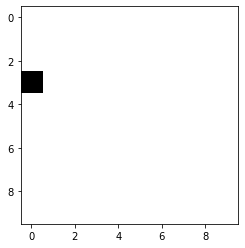

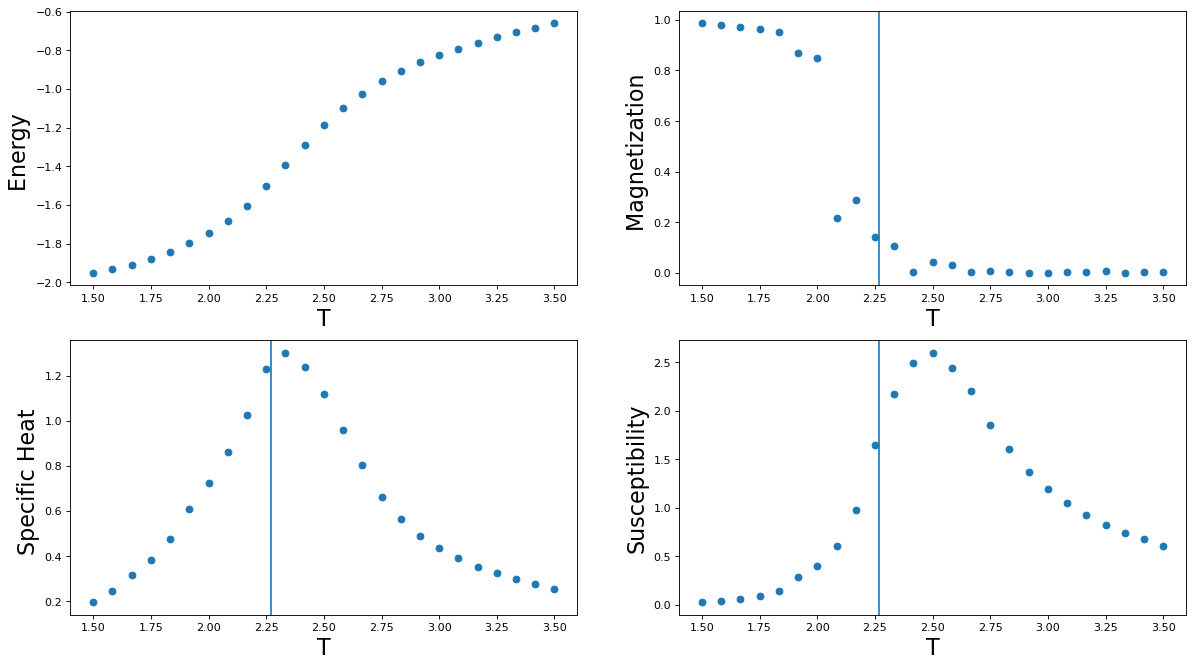

CPU times: user 13min 15s, sys: 1min 7s, total: 14min 23s
Wall time: 12min 36s


In [44]:
%%time

energy = []
magnetization = []
CV = []
susceptibility = []

e, m, states = MC(crbms[-1], states, 2 * 10 ** 4)
for i, crbm in enumerate(crbms[::-1]):
    # Warmup
    e, m, states = MC(crbm, states, 10 ** 3)
    
    # Mc Simulation
    e, m, states = MC(crbm, states,  2 * 10 ** 4)
    
    # Computing expectaion values
    e1 = e.mean()
    e2 = (e ** 2).mean()
    
    m1 = m.mean()
    absm1= abs(m).mean()
    m2 = (m ** 2).mean()
    
    
    energy.append(e1 / L ** 2)
    magnetization.append(m1 / L ** 2)
    CV.append( (e2 - e1 ** 2) / Ts[-i - 1] ** 2 / L ** 2 )
    susceptibility.append( (m2 - absm1 ** 2) / Ts[-i - 1] / L ** 2 )
    
    
    display.clear_output(wait=True)
    print("Temp: ", Ts[-i -1])
    plt.imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    plt.show()
    
    # Plot thermodynamics
    plot_thermodynamics(Ts[-i - 1:], energy[::-1], CV[::-1], magnetization[::-1], susceptibility[::-1])

Above you can see that the Magnetization colapses to 0 after the critical temperature $T_c=2.269$ and that the specific heat is maximal around $T_c$ as expected.

In [45]:
t1 = time.time()
(t1 - t0) / 60

16.271534983317057